# Загружаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import calendar

# Загружаем и проверяем датасеты

In [2]:
DF_auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkin-41/shared/problem1-auth_data.csv', sep=';') # Данные о времени захода пользователей в игру
DF_reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkin-41/shared/problem1-reg_data.csv', sep=';') # Данные о времени регистрации

In [3]:
# Проверка данных активности пользователей. Также важно отметить, что данные о дате и времени захода в столбце auth_ts
# представлены в виде целого значения. Далее, нам предстоит перевести эти значения в формат timestamp и datetime.
print(
    'Размер датафрейма -', DF_auth.shape, '\n', '-----------------------------------------------------------------',
    '\nПроверка пропусков (пропусков нет) - \n', DF_auth.isna().sum(), '\n', '-----------------------------------------------------------------'
    '\nОтображение типов данных по колонкам \n', DF_auth.dtypes, '\n', '-----------------------------------------------------------------')

Размер датафрейма - (9601013, 2) 
 ----------------------------------------------------------------- 
Проверка пропусков (пропусков нет) - 
 auth_ts    0
uid        0
dtype: int64 
 -----------------------------------------------------------------
Отображение типов данных по колонкам 
 auth_ts    int64
uid        int64
dtype: object 
 -----------------------------------------------------------------


In [4]:
# Проверка данных по регистрации пользователей. Аналогично предыдущему датасету - данные о дате и времени мы переведем из int в datetime формат.
print(
    'Размер датафрейма -', DF_reg.shape, '\n', '-----------------------------------------------------------------',
    '\nПроверка пропусков (пропусков нет) - \n', DF_reg.isna().sum(), '\n', '-----------------------------------------------------------------'
    '\nОтображение типов данных по колонкам \n', DF_reg.dtypes, '\n', '-----------------------------------------------------------------')

Размер датафрейма - (1000000, 2) 
 ----------------------------------------------------------------- 
Проверка пропусков (пропусков нет) - 
 reg_ts    0
uid       0
dtype: int64 
 -----------------------------------------------------------------
Отображение типов данных по колонкам 
 reg_ts    int64
uid       int64
dtype: object 
 -----------------------------------------------------------------


# Работа с данными

In [5]:
# Совместим данные об активности и регистрации пользователей через левый джоин.
DF_Full = DF_auth.merge(DF_reg, on='uid', how='left')
DF_Full.head()

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089


In [6]:
# Переведем значения о дате из int в datetime.
DF_Full['auth_ts'] = pd.to_datetime(DF_Full['auth_ts'], unit='s').dt.date # unit = 's' - означает, что значения изначально представлены в секундах
DF_Full['reg_ts'] = pd.to_datetime(DF_Full['reg_ts'], unit='s').dt.date
DF_Full.head()

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22


In [7]:
# Посмотрим на количество регистраций и активность пользователей по годам.
DF_active = DF_Full.groupby('auth_ts', as_index=False).agg({'uid':'nunique'}).sort_values('auth_ts')
DF_regs = DF_Full.groupby('reg_ts', as_index=False).agg({'uid':'nunique'}).sort_values('reg_ts')

Text(0.5, 1.0, 'Количество регистраций по дате')

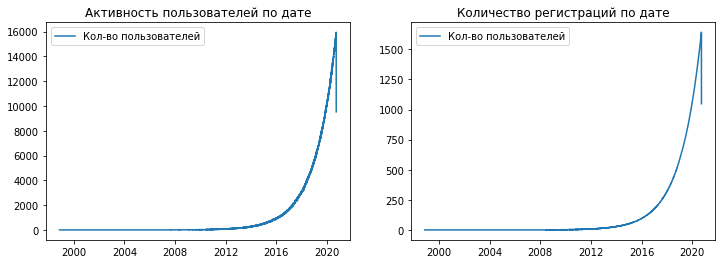

In [8]:
# Получим графики
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(DF_active['auth_ts'], DF_active['uid'], label='Кол-во пользователей')
plt.legend()
plt.title('Активность пользователей по дате')

plt.subplot(1, 2, 2)
plt.plot(DF_regs['reg_ts'], DF_regs['uid'], label='Кол-во пользователей')
plt.legend()
plt.title('Количество регистраций по дате')

# Функция расчета Retention по дням

In [9]:
# Функция для расчета метрики Retention по дням.
def retention(df, start_period, end_period): # На вход в функцию подается датафрейм, содержащий в себе информацию о времени  
    # захода и регистрации юзера, а также границы временного диапазона (в формате строки - '2020-07-01'), который нас интересует.

    # Переводим временные данные из формата str в datetime
    start_date = pd.to_datetime(start_period).date()
    end_date = pd.to_datetime(end_period).date()

    # Считаем количество дней между датами захода в игру и регистрацией.
    df['length'] = (df['auth_ts'] - df['reg_ts']).dt.days + 1
    df = df.loc[(df['reg_ts'] > start_date) & (df['reg_ts'] < end_date)] # Выделяем заданный промежуток времени.

    # Группируем данные по дате регистрации и столбцу с количеством дней спустя регистрации, считаем количество уникальных пользователей.
    df_groupped = df.groupby(['reg_ts', 'length'], as_index=False).agg({'uid':'nunique'}).rename(columns={'uid':'number_users'})
    df_groupped = df_groupped.pivot(index='reg_ts', columns='length', values='number_users')

    # Считаем метрики. Деление строк, где каждая строка является дневной когортой, на количество пользователей в первом дне каждой когорты.
    retention = df_groupped.divide(df_groupped[1], axis=0).round(2) # Далее результаты округляем до 2 знаков после запятой.
    
    # Создаем имя месяца и год 
    month_name = start_date.strftime('%B')
    year = start_date.year

    # Строим тепловую карту метрики Retention
    plt.figure(figsize=(18,14))
    plt.title(f'Таблица метрики Retention за месяц ({month_name}, {year})')
    ax = sns.heatmap(data=retention.iloc[:,0:31], annot=True, fmt='.0%', vmin=0.0, vmax=1,cmap='Blues')
    ax.set_yticklabels(retention.index)

    return df_groupped.iloc[:,0:31]

##### Функция возвращает:
1. Таблицу с заданным диапазоном времени и количеством уникальных пользоватетей в заданные периоды.
2. Отображение Retention в виде тепловой карты в процентах за определенные периоды времени.

length,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-06-02,1365.0,24.0,45.0,66.0,80.0,78.0,97.0,77.0,50.0,74.0,...,56.0,54.0,55.0,43.0,49.0,29.0,39.0,35.0,44.0,51.0
2020-06-03,1368.0,27.0,49.0,66.0,49.0,77.0,96.0,85.0,57.0,80.0,...,43.0,47.0,55.0,46.0,57.0,50.0,41.0,38.0,50.0,37.0
2020-06-04,1369.0,25.0,54.0,57.0,68.0,88.0,82.0,75.0,61.0,72.0,...,55.0,55.0,48.0,50.0,46.0,41.0,49.0,41.0,42.0,39.0
2020-06-05,1372.0,27.0,46.0,57.0,62.0,75.0,94.0,60.0,58.0,72.0,...,55.0,46.0,43.0,44.0,44.0,38.0,56.0,43.0,45.0,41.0
2020-06-06,1375.0,28.0,50.0,67.0,66.0,82.0,100.0,76.0,69.0,78.0,...,64.0,42.0,45.0,47.0,39.0,36.0,49.0,40.0,37.0,38.0
2020-06-07,1376.0,19.0,60.0,72.0,66.0,81.0,75.0,96.0,58.0,70.0,...,49.0,47.0,37.0,46.0,42.0,49.0,42.0,37.0,38.0,38.0
2020-06-08,1379.0,24.0,38.0,62.0,79.0,82.0,95.0,62.0,71.0,56.0,...,52.0,47.0,58.0,42.0,45.0,42.0,42.0,56.0,43.0,35.0
2020-06-09,1381.0,26.0,53.0,57.0,82.0,73.0,92.0,79.0,64.0,72.0,...,53.0,43.0,48.0,49.0,44.0,41.0,45.0,36.0,50.0,30.0
2020-06-10,1383.0,19.0,52.0,66.0,66.0,94.0,118.0,80.0,73.0,56.0,...,52.0,55.0,54.0,47.0,48.0,43.0,39.0,43.0,52.0,48.0


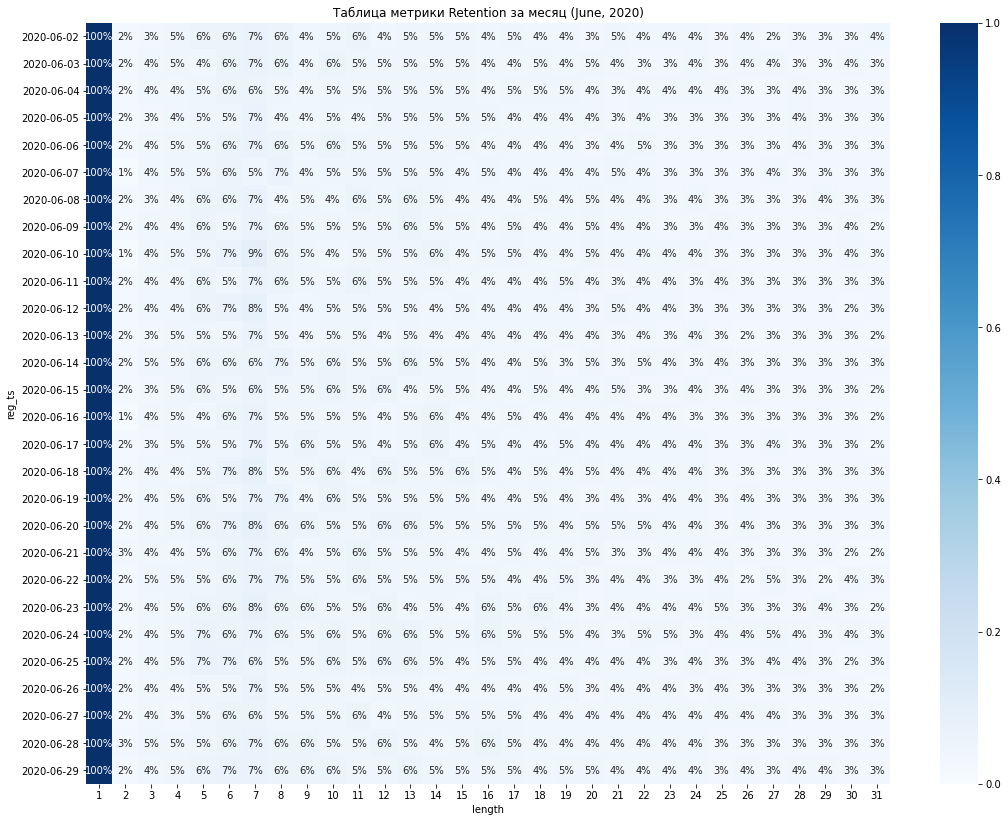

In [10]:
# Получим результат в виде таблицы, содержащей в себе показатели retention (в %) по дням месяца
retention(DF_Full, '2020-06-01','2020-06-30')